# Подготовка окружения

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, pipeline
from torch.utils.data import DataLoader
from torch.serialization import add_safe_globals
from configs.config import Config
from src.data_utils import process_dataset, split_dataset
from src.next_token_dataset import TextDataset
from src.lstm_model import LSTMModel, count_parameters, generate_samples
from src.lstm_train import train_model
from src.eval_lstm import calculate_rouge_lstm
from src.eval_transformer_pipeline import calculate_rouge_transformer

In [2]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
IS_TEST = True # тестовый сценарий для отладки кода на слабой машине
config = Config(is_test=IS_TEST)

tokenizer = AutoTokenizer.from_pretrained(config.tokenizer_name)
tokenizer.pad_token = tokenizer.pad_token or tokenizer.eos_token
config.pad_token_id = tokenizer.pad_token_id or tokenizer.eos_token_id
config.pad_token = tokenizer.pad_token
config.vocab_size = len(tokenizer)
print(f'вычисления на {config.device}\n')
print('\n параметры запуска')
vars(config)

вычисления на cuda


 параметры запуска


{'raw_ds_path': './data/raw_dataset.txt',
 'ds_processed_path': './data/dataset_processed.txt',
 'ds_train_path': './data/train.csv',
 'ds_val_path': './data/val.csv',
 'ds_test_path': './data/test.csv',
 'model_path': './models/lstm_model.pth',
 'max_raw__ds_length': 100,
 'batch_size': 16,
 'embedding_dim': 256,
 'hidden_dim': 128,
 'num_layers': 1,
 'dropout': 0.3,
 'learning_rate': 0.002,
 'num_epochs': 10,
 'max_length': 64,
 'train_val_split': 0.8,
 'text_split_on_prediction': 0.75,
 'device': 'cuda',
 'tokenizer_name': 'distilgpt2',
 'pad_token_id': 50256,
 'pad_token': '<|endoftext|>',
 'vocab_size': 50257}

# Подготовка датасета

### 1. Получение и очистка исходных текстов

In [3]:
file = config.raw_ds_path
if not os.path.exists(file):
    !wget https://code.s3.yandex.net/deep-learning/tweets.txt -O {file}


количество текстов: 100
статистика количества слов в тексте:
мин: 3
медиана: 14.00
среднее: 13.59
макс: 27
5-й перцентиль: 3.95
95-й перцентиль: 24.05


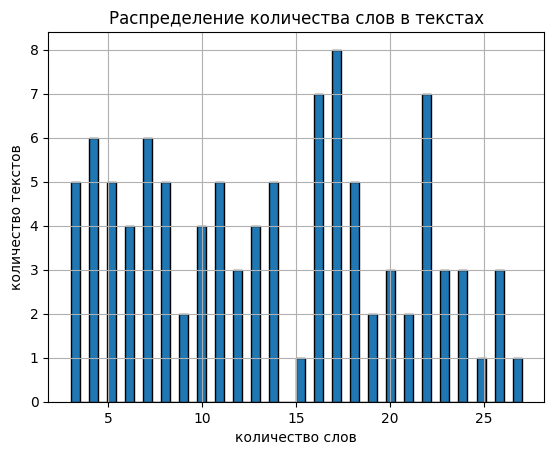


примеры чистых текстов:

www that s a bummer ou shoulda got avid arr of hird ay to do it
is upset that he can t update his acebook by texting it and might cry as a result chool today also lah
dived many times for the ball anaged to save 50 he rest go out of bounds
my whole body feels itchy and like its on fire
no it s not behaving at all i m mad why am i here because can t see you all over there


In [4]:
clean_corpus = process_dataset(config)

### 2. Разделение датасета на подсеты с сохранением в файлы 

In [5]:
train_texts, val_texts, test_texts = split_dataset(texts=clean_corpus,config=config)

# Подготовка Dataloaders

### 1. Инициализация Datasets

In [6]:
train_dataset = TextDataset(train_texts, tokenizer, config)
val_dataset = TextDataset(val_texts, tokenizer, config)
test_dataset = TextDataset(test_texts, tokenizer, config)

print(f'\ntrain_dataset len: ' ,len(train_dataset))
print(f'val_dataset len: ' ,len(val_dataset))
print(f'test_dataset len: ' ,len(test_dataset))


train_dataset len:  80
val_dataset len:  10
test_dataset len:  10


### 2. Инициализация Dataloaders

In [7]:
dl_config = {
    'batch_size': config.batch_size,
    'num_workers': 4,
    'pin_memory': config.device=='cuda',
    'persistent_workers': True,
    'prefetch_factor': 2,
}

train_dataloader = DataLoader(train_dataset, **dl_config, shuffle=True)
val_dataloader = DataLoader(val_dataset, **dl_config, shuffle=False)
test_dataloader = DataLoader(test_dataset, **dl_config, shuffle=False)

print(f'батчей в train: {len(train_dataloader)}')
print(f'батчей в val: {len(val_dataloader)}')
print(f'батчей в test: {len(test_dataloader)}')

батчей в train: 5
батчей в val: 1
батчей в test: 1


# Обучение модели

### Инициализация модели

In [8]:
model = LSTMModel(config)
print('количество параметров: ', count_parameters(model))
model = model.to(config.device)

количество параметров:  19546577


In [9]:
criterion = nn.CrossEntropyLoss(ignore_index=config.pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

### Обучение и валидация

Модель на cuda:0


         сalc rouge metrics val: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it, rouge1 max=0.0000]


GPU 0===>:
current mem: 0.62 GB
reserved mem: 1.25 GB
max per epoch: 1.00 GB
=====>GPU 0
  train loss: 10.8215, val loss: 10.7755
  val rouge1: 0.0000, val rouge2: 0.0000
-------------------- end of epoch 1/10 -------------------- 



         сalc rouge metrics val: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, rouge1 max=0.0000]


GPU 0===>:
current mem: 0.62 GB
reserved mem: 1.25 GB
max per epoch: 1.12 GB
=====>GPU 0
  train loss: 10.6035, val loss: 10.7160
  val rouge1: 0.0000, val rouge2: 0.0000
-------------------- end of epoch 2/10 -------------------- 



         сalc rouge metrics val: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, rouge1 max=0.0000]


GPU 0===>:
current mem: 0.62 GB
reserved mem: 1.44 GB
max per epoch: 1.12 GB
=====>GPU 0
  train loss: 10.3197, val loss: 10.5373
  val rouge1: 0.0000, val rouge2: 0.0000
-------------------- end of epoch 3/10 -------------------- 



         сalc rouge metrics val: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it, rouge1 max=0.0000]


GPU 0===>:
current mem: 0.62 GB
reserved mem: 1.44 GB
max per epoch: 1.12 GB
=====>GPU 0
  train loss: 9.5270, val loss: 9.5745
  val rouge1: 0.0000, val rouge2: 0.0000
-------------------- end of epoch 4/10 -------------------- 



         сalc rouge metrics val: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, rouge1 max=0.0870]


GPU 0===>:
current mem: 0.62 GB
reserved mem: 1.44 GB
max per epoch: 1.12 GB
=====>GPU 0
  train loss: 7.8120, val loss: 8.6110
  val rouge1: 0.0256, val rouge2: 0.0000
-------------------- end of epoch 5/10 -------------------- 



         сalc rouge metrics val: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, rouge1 max=0.0784]


GPU 0===>:
current mem: 0.62 GB
reserved mem: 1.44 GB
max per epoch: 1.12 GB
=====>GPU 0
  train loss: 6.6750, val loss: 8.7246
  val rouge1: 0.0351, val rouge2: 0.0000
-------------------- end of epoch 6/10 -------------------- 



         сalc rouge metrics val: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it, rouge1 max=0.0816]


GPU 0===>:
current mem: 0.62 GB
reserved mem: 1.44 GB
max per epoch: 1.12 GB
=====>GPU 0
  train loss: 6.2249, val loss: 8.9350
  val rouge1: 0.0393, val rouge2: 0.0000
-------------------- end of epoch 7/10 -------------------- 



         сalc rouge metrics val: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, rouge1 max=0.0851]


GPU 0===>:
current mem: 0.62 GB
reserved mem: 1.44 GB
max per epoch: 1.12 GB
=====>GPU 0
  train loss: 6.0302, val loss: 9.1415
  val rouge1: 0.0437, val rouge2: 0.0000
-------------------- end of epoch 8/10 -------------------- 



         сalc rouge metrics val: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, rouge1 max=0.0800]


GPU 0===>:
current mem: 0.62 GB
reserved mem: 1.44 GB
max per epoch: 1.12 GB
=====>GPU 0
  train loss: 5.8625, val loss: 9.2910
  val rouge1: 0.0350, val rouge2: 0.0000
-------------------- end of epoch 9/10 -------------------- 



         сalc rouge metrics val: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it, rouge1 max=0.0800]


GPU 0===>:
current mem: 0.62 GB
reserved mem: 1.44 GB
max per epoch: 1.12 GB
=====>GPU 0
  train loss: 5.7631, val loss: 9.3747
  val rouge1: 0.0379, val rouge2: 0.0000
-------------------- end of epoch 10/10 -------------------- 



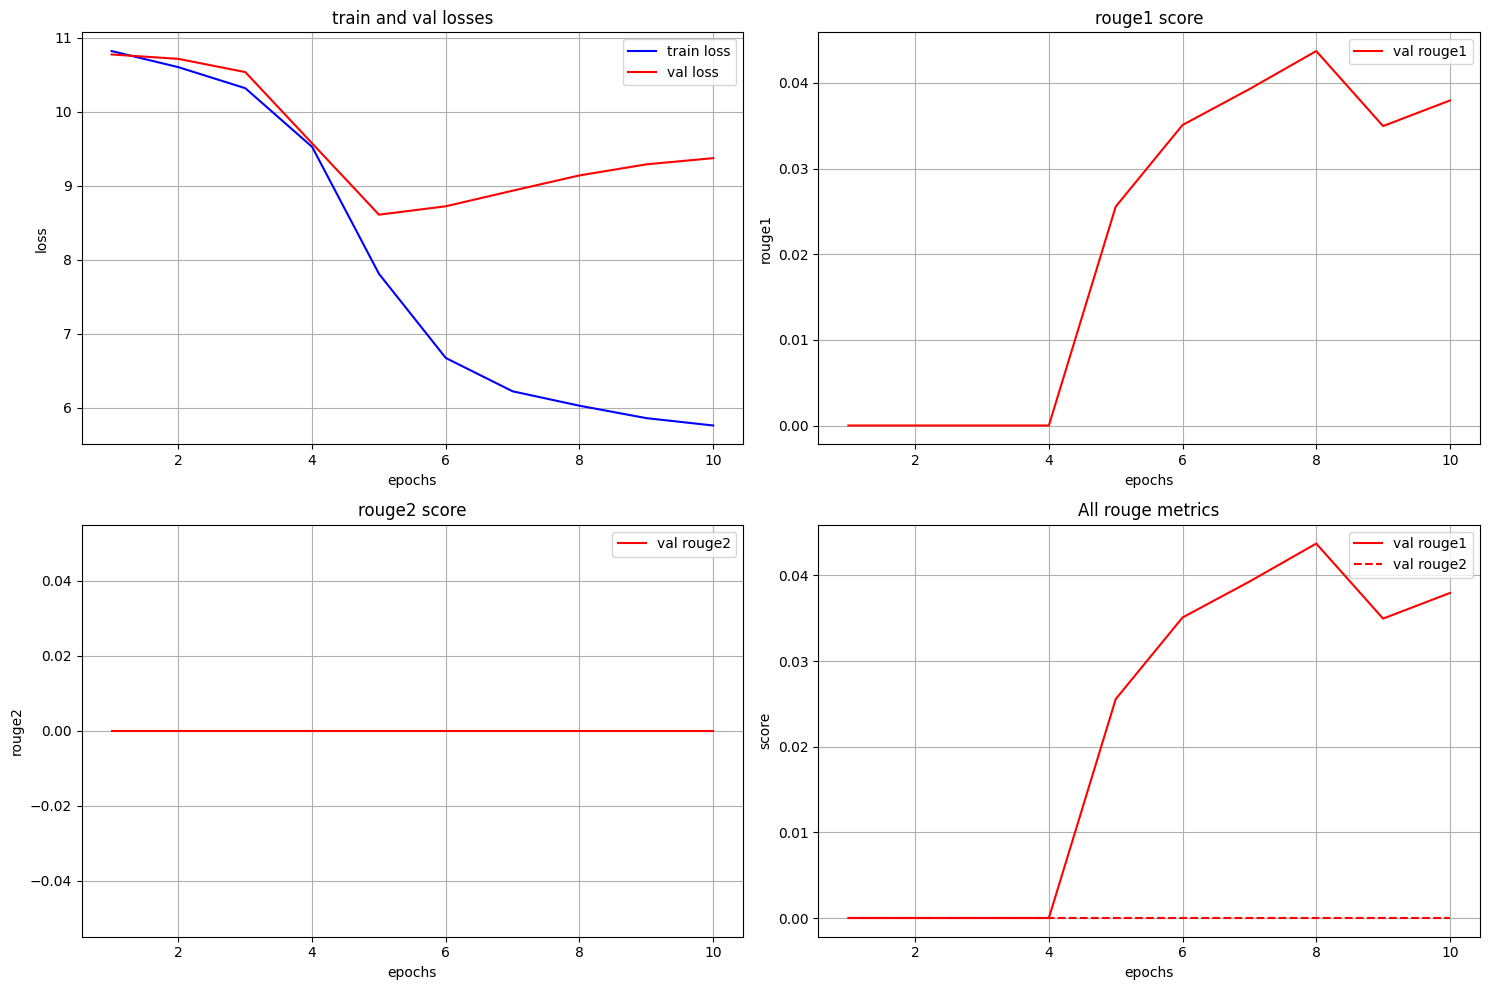

In [10]:
train_model(
    model,
    tokenizer,
    config,
    train_dataloader,
    val_dataloader,
    criterion,
    optimizer,
)

### Сохранение модели

In [11]:
torch.save({
        'model_state_dict': model.state_dict(),
        'config': config,
    }, config.model_path
    )

### Загрузка модели

In [12]:
add_safe_globals([Config])
checkpoint = torch.load(config.model_path, map_location=config.device)
model = LSTMModel(checkpoint["config"]).to(config.device)

model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

LSTMModel(
  (embedding): Embedding(50257, 256, padding_idx=50256)
  (lstm): LSTM(256, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=50257, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

### Генерация дополнения текстов

In [13]:
samples = random.sample(test_texts, 6)
generate_samples(model, tokenizer, config, samples)

asis:       ut vacation photos online a few yrs ago crashed and now forget  ->  the name of the site
generated:  ut vacation photos online a few yrs ago crashed and now forget  ->   ve from to show and willer the sn phone comes me am you in it not out in everyderans not didn phone so out for to don can i wish had do the in noond already cut teams likeac are music wonitus of sheve won most mad fine sorry bit update cut sn got and constants lot
rouge1: 0.0968,   rouge2: 0.0000

asis:       some1 hacked my account on aim now i have to  ->  make a new one
generated:  some1 hacked my account on aim now i have to  ->  mmty bracketah www over know and a part only has how know areaged is she my before see r getting finally massive too comes3 is with part wasn suit found eyes my watch goodao yast drinks party not wonder working to itac result never hills lost what sorry hates stillday have taking and are we rest
rouge1: 0.0333,   rouge2: 0.0000

asis:       o new csi  ->  tonight
generated:  o 

### Метрики модели на тестовой выборке

In [14]:

test_dataloader = DataLoader(test_dataset, **dl_config, shuffle=False)

r1, r2 = calculate_rouge_lstm(
    model, test_dataloader, tokenizer, config, prefix="test"
)
print(f"test rouge1: {r1:.4f}, test rouge2: {r2:.4f}")


         сalc rouge metrics test: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it, rouge1 max=0.1154]

test rouge1: 0.0356, test rouge2: 0.0000


# Сравнение с трансформером и выводы

### Метрики трансформера на тестовой выборке

In [15]:
generator = pipeline("text-generation", model="distilgpt2", device=config.device)
print('\nколичество параметров: ', count_parameters(generator.model), '\n')
print('\nтекстов в выборке: ', len(test_texts), '\n')
r1,r2 = calculate_rouge_transformer(generator, config, test_texts)
print(f"\ntest rouge1: {r1:.4f}, test rouge2: {r2:.4f}")

Device set to use cuda



количество параметров:  81912576 


текстов в выборке:  10 



         сalc rouge metrics test: 100%|██████████| 10/10 [00:02<00:00,  4.03it/s, rouge1 max=0.1111]


test rouge1: 0.0206, test rouge2: 0.0000
